# Synthetic data experiments for AIS-PF-MCMC

In [345]:
# Import all necesary libraries
import pandas as pd
import numpy as np
from scipy.optimize import newton
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from scipy.special import logsumexp

# Functions

In [15]:
def BM_SEIR(V_in, params, num_particles, N,m):
    num_steps = m + 1  
    h = 1 / num_steps 

    # Initialize arrays to store results
    V = np.zeros([V_in.shape[0], num_particles, num_steps + 1])    
    new_infected = np.zeros([num_particles])

    # Set initial conditions
    kappa, gamma, sigma = params[:3]    
    V[:,:,0] = V_in

    # Simulate the SIR model with diffuse infectious rate using Euler-Maruyama method
    for t in range(1, num_steps + 1):
        # Update SEIR model
        infections = np.exp(V[4,:,t-1]) * V[0, :, t-1] * V[2, :, t-1] / N 
        latent = kappa * V[1, :, t-1]
        recovered = gamma * V[2, :, t-1]
        
        V[0, :, t] = V[0, :, t-1] - infections*h                  # S-Susceptibles
        V[1, :, t] = V[1, :, t-1] + (infections  - latent)*h      # E-Exposed
        V[2, :, t] = V[2, :, t-1] + (latent - recovered)*h        # I-Infected
        V[3, :, t] = V[3, :, t-1] + recovered*h                   # R-Recovered
        
        # Update Latent State
        dB = stats.norm(0, 1).rvs(num_particles)
        V[4,:,t] = V[4,:,t-1] + sigma * np.sqrt(h) * dB
        
        # Update weekly infected count
        new_infected += infections*h 
    
    return V[:,:,-1], new_infected

In [481]:
def log_cess(alpha, alpha_t, log_liks):
    """
    log cESS for uniform previous weights:
      cESS = (sum_i exp(delta * l_i))^2 / sum_i exp(2*delta * l_i)
    returns log(cESS) computed stably.
    """
    delta = max(0.0, float(alpha - alpha_t))
    a = delta * log_liks

    # handle degenerate case: all -inf or all identical
    if not np.any(np.isfinite(a)):
        return -np.inf  # cESS ~ 0
    # If all log_liks equal (variance ~ 0), cESS = N for any delta
    if np.nanstd(log_liks) == 0.0:
        # return log(N) (we don't know N here; caller subtracts log(target*N))
        # We can detect N as len(log_liks)
        return np.log(len(log_liks))

    lse1 = logsumexp(a)        # log Σ exp(a_i)
    lse2 = logsumexp(2.0 * a)  # log Σ exp(2 a_i)
    return 2.0 * lse1 - lse2

def d_log_cess(alpha, alpha_t, log_liks):
    """
    d/d alpha of log cESS = 2*(E1 - E2),
    where E1 = Σ s1_i * l_i with s1 = softmax(delta * l),
          E2 = Σ s2_i * l_i with s2 = softmax(2*delta * l).
    Works stably in log-space.
    """
    delta = max(0.0, float(alpha - alpha_t))
    a = delta * log_liks

    # softmax weights for a and for 2a
    lse1 = logsumexp(a)
    lse2 = logsumexp(2.0 * a)

    # guard degenerate cases
    if not np.isfinite(lse1) or not np.isfinite(lse2):
        return 0.0

    s1 = np.exp(a - lse1)            # normalized weights for a
    s2 = np.exp(2.0 * a - lse2)      # normalized weights for 2a

    # expectations under s1 and s2
    E1 = np.sum(s1 * log_liks)
    E2 = np.sum(s2 * log_liks)
    return 2.0 * (E1 - E2)


def find_alpha_newton(alpha_prev, log_likelihoods, target_cess_ratio, tol=1e-4):
    N = len(log_likelihoods)
    target_log_cess = np.log(target_cess_ratio * N)

    f = lambda alpha: log_cess_resampling(alpha, alpha_prev, log_likelihoods) - target_log_cess
    fprime = lambda alpha: d_log_cess_resampling(alpha, alpha_prev, log_likelihoods)
    
    # Initial guess: small step forward
    alpha_init = min(alpha_prev + 0.001, 1.0)

    try:
        alpha_star = newton(func=f, x0=alpha_init, tol=tol, maxiter=10)
        alpha_star = np.clip(alpha_star, alpha_prev + 1e-4, 1.0)
    except RuntimeError:
        alpha_star = min(alpha_prev + 0.001, 1.0)

    delta_alpha = alpha_star - alpha_prev
    return delta_alpha, alpha_star

In [487]:
def run_mcmc_jitter(particles_t, particles_tplus1, weekly_infections_tplus1, current_params, log_likelihoods, Y_obs_tplus1, alpha, overdispersion, N):
    num_particles = particles_t.shape[1]
    for _ in range(1):  # fixed number of MCMC loops
        # Propose new betas for all particles
        step_scale = 0.5*np.std(particles_t[-1])
        proposed_betas = particles_t[-1] + np.random.normal(0, step_scale, size=num_particles)

        # Build proposed current states
        proposed_states = particles_t.copy()
        proposed_states[-1, :] = proposed_betas

        # Propagate to t+1 for all particles
        proposed_next_states, proposed_infs = BM_SEIR(proposed_states, current_params, num_particles, N, 0)
        
        # Mark invalid proposals (negative or non-finite infections)
        valid_mask = (proposed_infs >= 0) & (np.isfinite(proposed_infs))
        
        # Compute proposed log-likelihoods
        proposed_ll = np.full(num_particles, -np.inf)  # start with -inf
        if np.any(valid_mask):
            p = 1 / (1 + overdispersion * proposed_infs[valid_mask])
            proposed_ll[valid_mask] = stats.nbinom(n=1 / overdispersion, p=p).logpmf(Y_obs_tplus1)

            # Metropolis–Hastings accept/reject step
            log_accept = np.minimum(0.0, alpha * (proposed_ll - log_likelihoods))
            accept = np.log(np.random.rand(num_particles)) < log_accept
            #print(accept.mean())

            # Update accepted particles
            if np.any(accept):
                idxs = np.where(accept)[0]
                particles_t[-1, idxs] = proposed_betas[idxs]
                particles_tplus1[:, idxs] = proposed_next_states[:, idxs]
                weekly_infections_tplus1[idxs] = proposed_infs[idxs]
                log_likelihoods[idxs] = proposed_ll[idxs]

    return particles_t, particles_tplus1, weekly_infections_tplus1, log_likelihoods

In [436]:
def run_adaptive_ais_step(particles_t, particles_tplus1, weekly_infectionstplus1, current_params, log_likelihoods, Y_obs_t, N, alpha_prev, target_cess_ratio, overdispersion):
    num_particles = particles_t.shape[1]
    ais_log_weights = np.zeros(num_particles)
    annealing_schedule = [alpha_prev]
    tol = 1e-4
    max_annealing_steps = 100
    annealing_step = 0
    logZ_tplus1 = 0.0


    while (1.0 - alpha_prev > tol) and (annealing_step < max_annealing_steps):
        # 1. Find optimal delta_alpha using Newton and cESS    
        delta_alpha, alpha_new = find_alpha_newton(alpha_prev=alpha_prev,log_likelihoods=log_likelihoods, target_cess_ratio=target_cess_ratio)
        
        # 2. Update log weights based on current delta_alpha
        ais_log_weights = delta_alpha * log_likelihoods
        log_sum_w = logsumexp(ais_log_weights)
        ais_norm_weights = np.exp(ais_log_weights - log_sum_w)
        
        logZ_tplus1 += log_sum_w - np.log(num_particles)
        
        # 3. Systematic Resampling
        r = np.random.uniform()
        positions = (np.arange(num_particles) + r) / num_particles
        resample_indices = np.searchsorted(np.cumsum(ais_norm_weights), positions)

        particles_t = particles_t[:, resample_indices]
        particles_tplus1 = particles_tplus1[:, resample_indices]
        weekly_infectionstplus1 = weekly_infectionstplus1[resample_indices]
        log_likelihoods = log_likelihoods[resample_indices]

        # MCMC jitter
        particles_t, particles_tplus1, weekly_infectionstplus1, log_likelihoods = run_mcmc_jitter(
            particles_t, particles_tplus1, weekly_infectionstplus1, current_params, 
            log_likelihoods, Y_obs_t, alpha_new, overdispersion, N
        )
        
        alpha_prev = alpha_new
        annealing_schedule.append(alpha_prev)
        annealing_step += 1
        
    return particles_t, particles_tplus1, weekly_infectionstplus1, log_likelihoods, logZ_tplus1

In [437]:
def AIS_BPF(Y_obs, N, T, num_particles, current_params, initial_conditions, BM_SEIR, m, overdispersion):
    # Initialize BPF variables
    particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
    weekly_infections = np.zeros([num_particles, T+1])

    ancestry_matrix = np.zeros([num_particles, T+1])
    loglikelihood = 0
    
    # Define values at time t=0
    particles[:, :, 0] = initial_conditions
    weekly_infections[:,0] = particles[2, :, 0]

    resample_indices = np.arange(num_particles)
    ancestry_matrix[:,0] = resample_indices
    
    for t in range(1, T+1):        
        # 1. Propagate
        particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:,resample_indices,t-1], current_params, num_particles, N, m)
        
        # 2. Compute incremental weights to be used in AIS
        log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,t])).logpmf(Y_obs[t])
    
        # 3. Run AIS step 
        particles[:,:,t-1], particles[:,:,t], weekly_infectionstplus1, log_likelihoods, logZ_tplus1= run_adaptive_ais_step(
            particles[:,:,t-1], particles[:,:,t], weekly_infections[:,t], current_params, log_likelihoods, Y_obs[t], N, alpha_prev=0.0,
            target_cess_ratio=0.99, overdispersion=overdispersion
        )

        weekly_infections[:,t] = weekly_infectionstplus1
        loglikelihood += logZ_tplus1

    chosen_index = np.random.choice(a=np.arange(num_particles), size=1, p=np.ones(num_particles)/num_particles)
    
    return loglikelihood, weekly_infections[ancestry_matrix[chosen_index, -1].astype(int),:], particles[:,ancestry_matrix[chosen_index, -1].astype(int),:]

# Import Covid-19 data

In [23]:
pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))

Total Population:  126014024
0.01% of Population:  126014


In [50]:
# Import COVID data
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
print(weekly_covid_df.head())

pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))

        date  confirmed_cases  confirmed_deaths
0 2020-02-23              4.0               0.0
1 2020-03-01             23.0               0.0
2 2020-03-08            131.0               0.0
3 2020-03-15            624.0               0.0
4 2020-03-22           1152.0               6.0
Total Population:  126014024
0.01% of Population:  126014


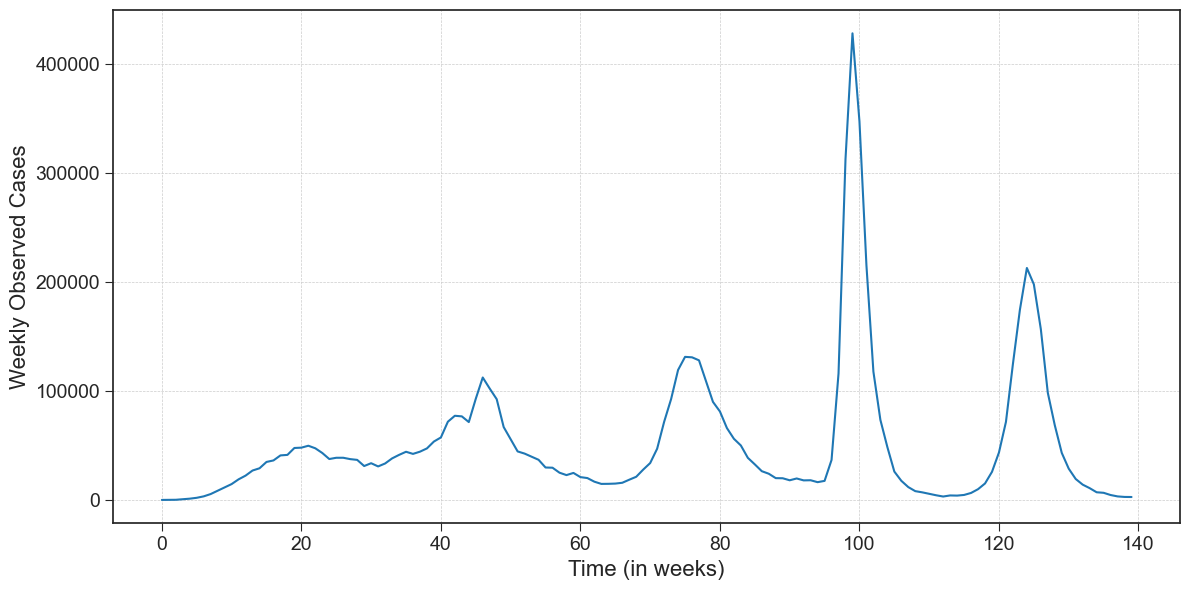

In [51]:
Y_obs = weekly_covid_df['confirmed_cases'].values[:140]

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(Y_obs)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

## Cambios en MCMC - Jitter

In [124]:
# Define prior distributions for model parameters and initial value conditions of the state space model
m = 0
T = Y_obs.shape[0]-1
num_particles = 1000

E0 = stats.uniform(0,0.0001*N).rvs(num_particles)
I0 = np.ones(num_particles)*Y_obs[0]
initial_conditions = np.array([
    np.ones(num_particles)*N - E0 - I0,
    E0,
    I0,
    np.zeros(num_particles),
    np.log(stats.uniform(0,2).rvs(num_particles))
    ])

overdispersion = 0.6212418740345191

current_theta = np.array([
    stats.beta(11.4, 2.5).rvs(),
    stats.beta(12.1, 10.3).rvs(),
    stats.uniform(0,1).rvs()
])

print('Initial conditions: \n',np.mean(initial_conditions, axis=1))
print('Initial parameters: \n',current_theta)

Initial conditions: 
 [ 1.26007588e+08  6.43219764e+03  4.00000000e+00  0.00000000e+00
 -2.75878561e-01]
Initial parameters: 
 [0.85479115 0.52057105 0.00800962]


In [488]:
# Initialize BPF variables
particles = np.zeros([initial_conditions.shape[0], num_particles, T+1]) 
weekly_infections = np.zeros([num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
weekly_infections[:,0] = particles[2, :, 0]
weights[:,0] = 1 / num_particles
norm_weights[:,0] = weights[:,0]
ancestry_matrix[:,0] = np.arange(num_particles)
ESS[0] = num_particles


for t in range(1, T+1):
    # Propagate
    particles[:,:,t], weekly_infections[:,t] = BM_SEIR(particles[:,:,t-1], current_theta, num_particles, N, m)

    # Compute initial log-likelihoods
    log_likelihoods = stats.nbinom(n=1/overdispersion, p=1/(1+overdispersion*weekly_infections[:,t])).logpmf(Y_obs[t])

    # Run AIS + MCMC at time t
    particles[:,:,t-1], particles[:,:,t], weekly_infectionstplus1, log_likelihoods, logZ_tplus1 = run_adaptive_ais_step(
        particles[:,:,t-1], particles[:,:,t], weekly_infections[:,t], current_theta, log_likelihoods, Y_obs[t], N, alpha_prev=0.0,
        target_cess_ratio=0.99, overdispersion=overdispersion
    )
    weekly_infections[:,t] = weekly_infectionstplus1
    loglikelihood += logZ_tplus1
    
print(loglikelihood)

-1591.6118650716073


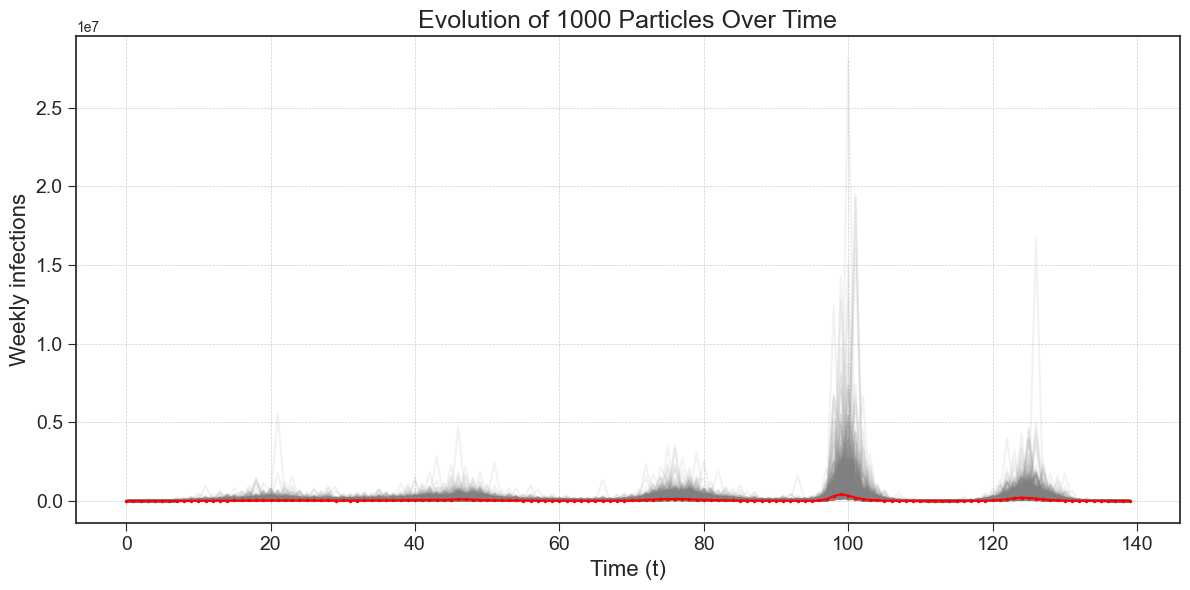

In [489]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')

for i in range(0,1000):
     plt.plot(weekly_infections[i,:], color='grey', alpha=0.1)
plt.plot(Y_obs, color='r', marker='o', markersize=1.5)

plt.xlabel('Time (t)', fontsize=16)
plt.ylabel('Weekly infections', fontsize=16)
plt.title('Evolution of 1000 Particles Over Time', fontsize=18)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

-1590.894635469068

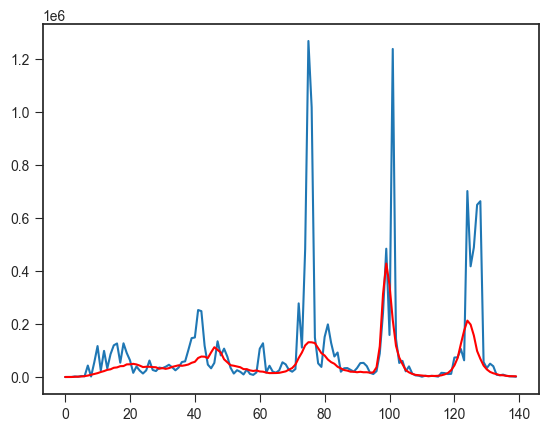

In [490]:
LL, infection_trayectory, particles_trayectory = AIS_BPF(Y_obs, N, T, num_particles, current_theta, initial_conditions, BM_SEIR, m, overdispersion)
plt.plot(infection_trayectory[0])
plt.plot(Y_obs, color='r')
LL